# Get on crop

In [1]:
# Import primary functions
import joblib
import json
import keras
import pathlib
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Import secondary functions
from pathlib import Path
from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define plot units
plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

2024-05-31 10:41:35.643522: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 10:41:35.643650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 10:41:35.775515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Advanced settings
CFG = {
    'n_splits':5,
    'batch_size':128,
    'num_epochs':15,
    'max_lr':5e-4,
    'warmup_pct':0.2,
    'n_tabular_layers':2,
    'img_backbone_final_dim':128,
    'tabular_hsizes':[256, 128],
    'n_ff_layers':2,
    'ff_hsizes':[128, 64]
}

# Just let 'em load

In [3]:
# Load the data
path = Path('/kaggle/input/planttraits2024/')
imgs_train = path / 'train_images'
imgs_test = path / 'test_images'

train = pd.read_csv(path / 'train.csv')
train['img_path'] = train['id'].apply(lambda x: imgs_train / f'{x}.jpeg')

test = pd.read_csv(path / 'test.csv')
test['img_path'] = test['id'].apply(lambda x: imgs_test / f'{x}.jpeg')

In [5]:
# Define targets
targets = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']
target_cols = [f'{col}_mean' for col in targets]

target_cols

['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

In [6]:
# Remove 'sd' columns
sd_cols = [f'{col}_sd' for col in targets]
train = train.drop(columns = sd_cols)

In [7]:
# Show first five rows of the train dataset
train.head()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean,img_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,0.472432,0.448272,0.403038,0.401753,11.758108,0.117484,1.243779,1.849375,50.216034,/kaggle/input/planttraits2024/train_images/192...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.279112,0.294724,0.311158,0.480334,15.748846,0.389315,0.642940,1.353468,574.098472,/kaggle/input/planttraits2024/train_images/195...
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,0.455066,0.458448,0.455440,0.796917,5.291251,8.552908,0.395241,2.343153,1130.096731,/kaggle/input/planttraits2024/train_images/196...
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,0.350208,0.349995,0.348838,0.525236,9.568305,1.083629,0.154200,1.155308,1042.686546,/kaggle/input/planttraits2024/train_images/195...
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,0.488996,0.457526,0.448166,0.411821,14.528877,0.657585,10.919966,2.246226,2386.467180,/kaggle/input/planttraits2024/train_images/195...


In [8]:
# Show first five rows of the test dataset
test.head()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,img_path
0,201238668,8.086756,2246.500000,127.321426,20.423418,353.381042,17.535713,80,109,90,...,0.389460,0.387536,0.374910,0.363712,0.364623,0.379435,0.388294,0.398887,0.397853,/kaggle/input/planttraits2024/test_images/2012...
1,202310319,10.844286,495.871429,28.023809,18.738306,786.554382,29.292856,130,155,142,...,0.300813,0.332776,0.314386,0.291168,0.280947,0.277623,0.276503,0.271212,0.272672,/kaggle/input/planttraits2024/test_images/2023...
2,202604412,8.105556,378.328583,39.928570,41.885647,722.071167,34.853809,133,134,139,...,0.418509,0.437172,0.453239,0.445230,0.435441,0.432758,0.429839,0.417250,0.394216,/kaggle/input/planttraits2024/test_images/2026...
3,201353439,7.077679,878.785706,70.428574,37.045235,669.389343,25.150000,103,140,116,...,0.313667,0.352311,0.401131,0.513455,0.519174,0.474007,0.469071,0.408466,0.366724,/kaggle/input/planttraits2024/test_images/2013...
4,195351745,4.790555,2299.366699,150.199997,24.136568,462.887695,22.516666,85,114,98,...,0.506952,0.462181,0.397052,0.358262,0.369279,0.414420,0.469002,0.519534,0.521837,/kaggle/input/planttraits2024/test_images/1953...


# Cropping express

In [9]:
# String conversion
img_paths = train['img_path'].astype(str).values
tabular = train.drop(columns = ['id', 'img_path'] + target_cols)
Y = train[target_cols]

In [10]:
# Remove unwanted observations
upper_quantiles = Y.quantile(0.98)
retained_flag = (Y < upper_quantiles).all(axis=1) & (Y > 0).all(axis=1)
img_paths = img_paths[retained_flag]
tabular = tabular[retained_flag]
Y = Y[retained_flag]

# Display the number of removed datas
print(f'Number of unwanted observations excluded: {retained_flag.shape[0] - retained_flag.sum()}')

Number of unwanted observations excluded: 5691


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

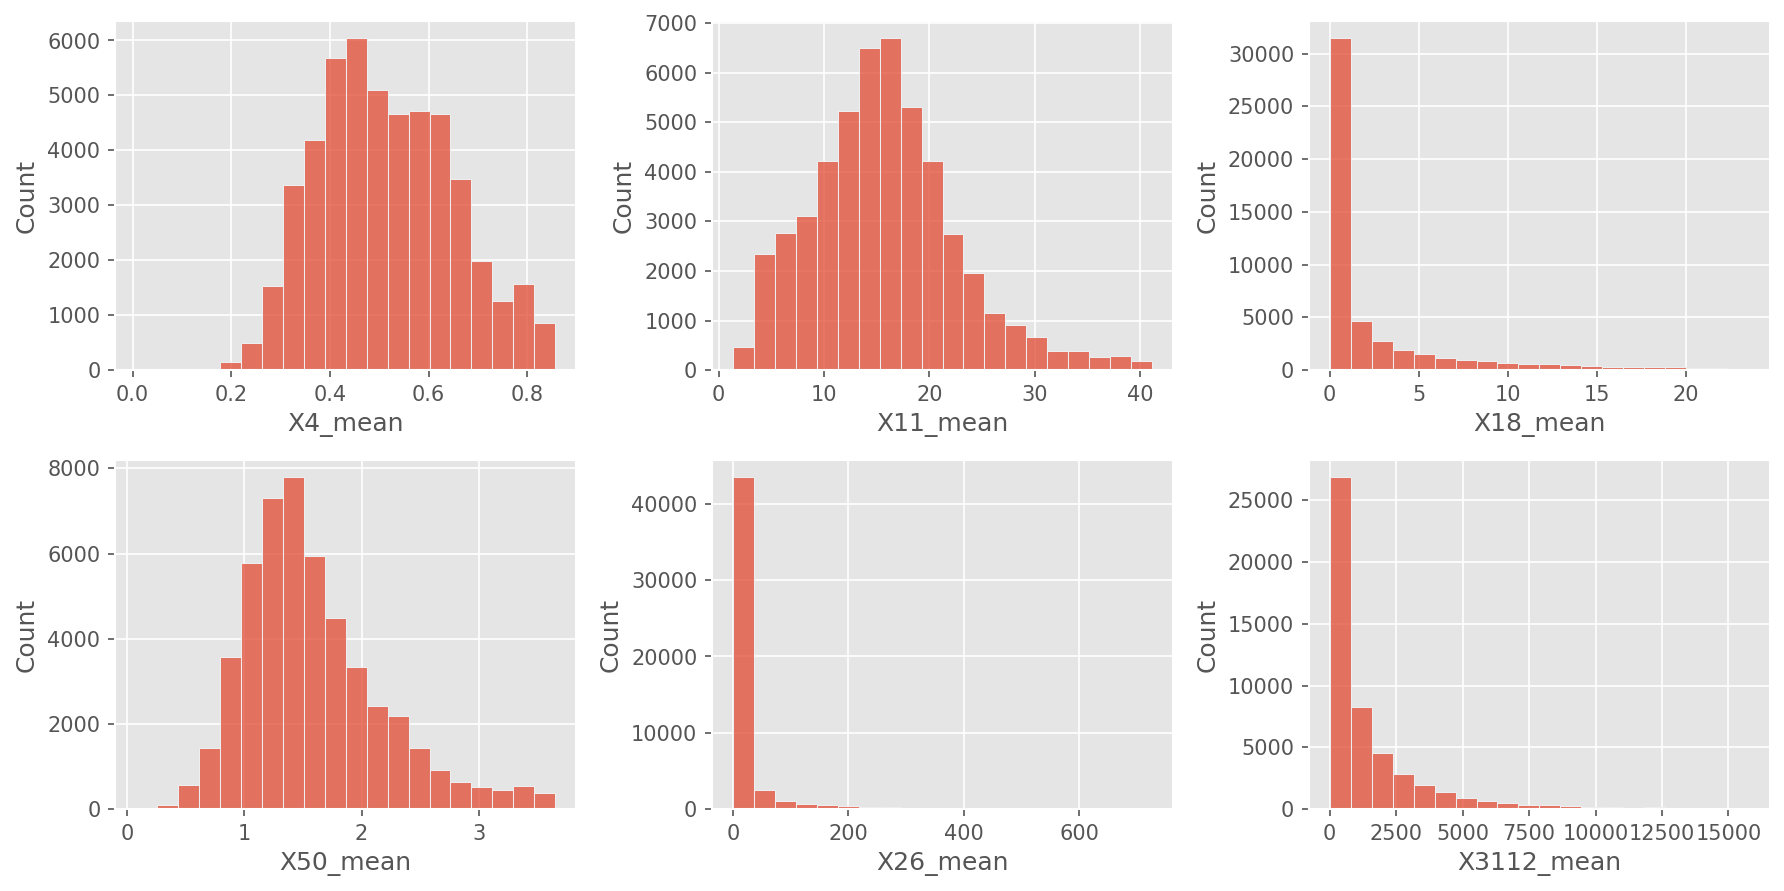

In [17]:
# Define histogram dependencies
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))

for i, column in enumerate(Y.columns):
    row_idx, col_idx = divmod(i, n_cols)
    _ = sns.histplot(data=Y, x=column, ax=axs[row_idx, col_idx], bins=20)
    
fig.tight_layout()

In [18]:
# Standardize statistics
output_sc = StandardScaler()
Y_sc = output_sc.fit_transform(Y)
_ = joblib.dump(output_sc, 'output_scaler.pkl')

# Tabular on duty

## Correlation matrix

In [19]:
corr_matrix = tabular.corr(method='spearman')

## Dissimilarity matrix

In [20]:
dissimilarity = 1 - abs(corr_matrix.values)

## Hierarchical clustering

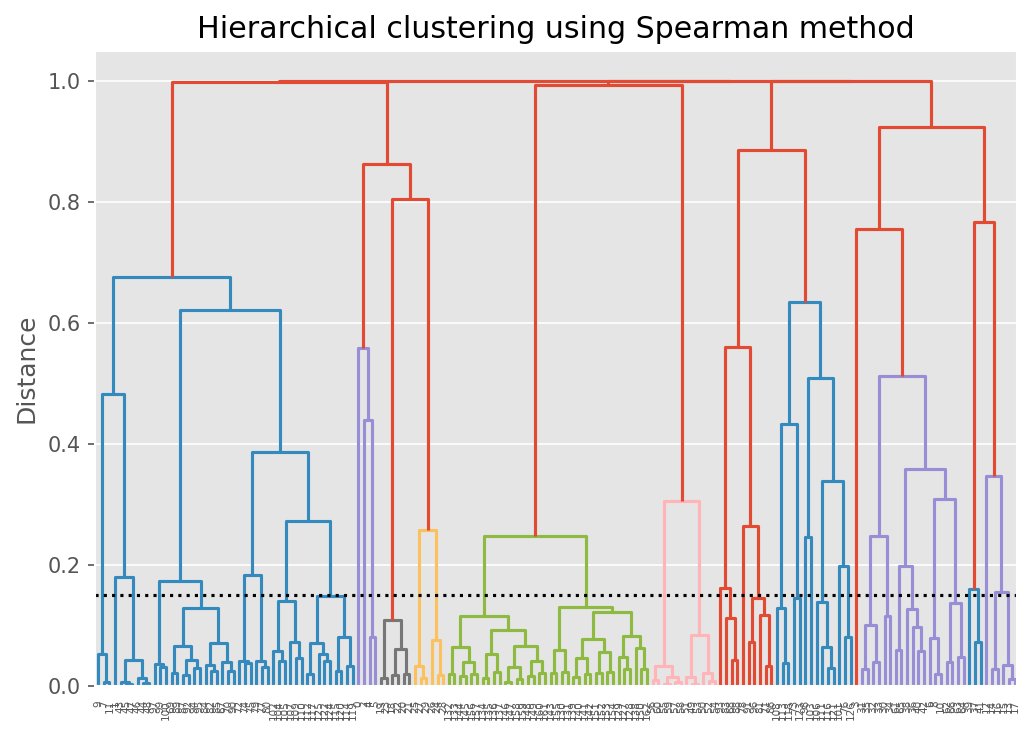

In [26]:
# Perform hierarchical clustering process
linkage_matrix = hierarchy.linkage(squareform(dissimilarity), method='complete')

# Define dendrogram dependencies
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
dendogram = hierarchy.dendrogram(
    linkage_matrix,
    ax=ax
)

_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering using Spearman method')
_ = ax.axhline(0.15, 0, 1, linestyle='dotted', color='k')
_ = ax.grid(False, axis='x')

fig.tight_layout()

In [27]:
# Acquire cluster labels
threshold = 0.15

cluster_labels = hierarchy.fcluster(linkage_matrix, threshold, criterion='distance')
n_clusters = np.unique(cluster_labels).shape[0]

# Display the number of clusters
print(f'Number of clusters: {n_clusters}\n')

Number of clusters: 42



In [28]:
cluster_features = {}

# Show features along with the clusters
for label in range(1, n_clusters + 1):
    print(f'Cluster {label}')
    
    leaves_in_cluster = cluster_labels == label
    cluster_features[label] = corr_matrix.columns[leaves_in_cluster].tolist()
    
    print(cluster_features[label])
    
with open('feature_clusters.json', 'w') as f:
    json.dump(cluster_features, f)

Cluster 1
['SOIL_bdod_100.200cm_mean_0.01_deg', 'SOIL_bdod_30.60cm_mean_0.01_deg', 'SOIL_bdod_60.100cm_mean_0.01_deg']
Cluster 2
['SOIL_phh2o_0.5cm_mean_0.01_deg', 'SOIL_phh2o_100.200cm_mean_0.01_deg', 'SOIL_phh2o_15.30cm_mean_0.01_deg', 'SOIL_phh2o_30.60cm_mean_0.01_deg', 'SOIL_phh2o_5.15cm_mean_0.01_deg', 'SOIL_phh2o_60.100cm_mean_0.01_deg']
Cluster 3
['WORLDCLIM_BIO12_annual_precipitation']
Cluster 4
['MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m4', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m4', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m4']
Cluster 5
['MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12', 'MODIS_2000

## Single feature

In [29]:
final_features = []

for cols_in_cluster in cluster_features.values():
    final_features.append(cols_in_cluster[0])

tabular = tabular[final_features]

## Minimum-maximum normalization

In [30]:
tabular_input_sc = MinMaxScaler()
tabular_sc = tabular_input_sc.fit_transform(tabular).astype(np.float32)

_ = joblib.dump(tabular_input_sc, 'tabular_input_scaler.pkl')

# Lights, camera, polinate!

In [31]:
# Image preprocessing
def process_image_from_file(file_path:str) -> tf.Tensor:
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = preprocess_input(img)
    
    return img

# Define dataset processing functions
def process_path(file_path, tabular, targets):
    return (process_image_from_file(file_path), tabular), targets

def process_paths_wo_targets(file_path, tabular):
    return ((process_image_from_file(file_path), tabular),)

# Trying to build the test

In [35]:
def create_model(backbone, num_steps_per_epoch):
    # Image processing
    img_input = keras.layers.Input(shape = (224, 224, 3), name="img_input")
    
    # Augmentation layers
    img_backbone = keras.Sequential([
        keras.Sequential([
            keras.layers.RandomRotation(factor=0.1, interpolation='nearest'),
            keras.layers.RandomTranslation(
                height_factor=0.1, width_factor=0.1, interpolation='nearest'
            ),
            keras.layers.RandomZoom(height_factor=(0.05, 0.15)),
            keras.layers.RandomFlip(mode="horizontal_and_vertical")
        ], name='augmentation'),
        backbone,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(CFG['img_backbone_final_dim'])
    ], name='img_backbone')
    
    # Reset EfficientNet weights
    img_backbone.get_layer('efficientnetv2-b0').trainable = False
    img_output = img_backbone(img_input)
    
    # Tabular processing
    tabular_input = keras.layers.Input(shape = (tabular_sc.shape[1],) , name="tabular_input")
    
    backbone_blocks = []
    for i in range(CFG['n_tabular_layers']):
        backbone_blocks.extend([
            keras.layers.Dense(CFG['tabular_hsizes'][i], name=f'tabular_block_{i}_dense'),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.Dropout(0.1)
        ])
    
    tabular_backbone = keras.Sequential(backbone_blocks, name='tabular_backbone')
    tabular_output = tabular_backbone(tabular_input)
    
    # Concatenation
    output = keras.layers.Concatenate()([img_output, tabular_output])
    
    for i in range(CFG['n_ff_layers']):
        output = keras.layers.Dense(CFG['tabular_hsizes'][i], name=f'ff_block_{i}_dense')(output)
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.ReLU()(output)
        output = keras.layers.Dropout(0.1)(output)
    
    output = keras.layers.Dense(6, name='output')(output)
    model = keras.Model(inputs=[img_input, tabular_input], outputs=output)
    
    num_steps_per_epoch = num_steps_per_epoch
    total_steps = CFG['num_epochs'] * num_steps_per_epoch
    warmup_steps = np.ceil(CFG['warmup_pct'] * total_steps).astype(int)
    
    lr_scheduler = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate = 1e-5,
        decay_steps = total_steps - warmup_steps,
        warmup_target= CFG['max_lr'],
        warmup_steps = warmup_steps
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler),
        loss= keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.R2Score()]
    )
    
    return model

# Go figure!

In [36]:
keras.backend.clear_session()

efficientnet_backbone = EfficientNetV2B0(include_top=False, weights='imagenet')
efficientnet_backbone.trainable = False

models_ensemble = [None] * CFG['n_splits']
histories = [None] * CFG['n_splits']
CV_splitter = KFold(n_splits=CFG['n_splits'], random_state=1, shuffle=True)
Y_cv_pred = Y_sc.astype(np.float32).copy()

for i, (idxs_train, idxs_val) in enumerate(CV_splitter.split(tabular_sc)):
    print(f'******************** Processing split {i + 1} ********************')
    
    # Training split
    paths_train = img_paths[idxs_train, ...]
    tabular_train = tabular_sc[idxs_train, ...]
    Y_train = Y_sc[idxs_train, ...]
    
    # Validation split
    paths_val = img_paths[idxs_val, ...]
    tabular_val = tabular_sc[idxs_val, ...]
    Y_val = Y_sc[idxs_val, ...]
    
    # Datasets with targets
    train_ds = tf.data.Dataset.from_tensor_slices((paths_train, tabular_train.astype(np.float32), Y_train.astype(np.float32)))
    val_ds = tf.data.Dataset.from_tensor_slices((paths_val, tabular_val.astype(np.float32), Y_val.astype(np.float32)))
    
    train_ds = train_ds.map(process_path).batch(CFG['batch_size'])
    val_ds = val_ds.map(process_path).batch(CFG['batch_size'])
    
    # Train model
    models_ensemble[i] = create_model(efficientnet_backbone, len(train_ds))
    histories[i] = models_ensemble[i].fit(train_ds, validation_data=val_ds, epochs=CFG['num_epochs'])
    
    # Save weights
    models_ensemble[i].save_weights(f"model_split{i+1}.weights.h5")
    
    # Compute out-of-fold predictions
    val_ds = tf.data.Dataset.from_tensor_slices((paths_val, tabular_val.astype(np.float32)))
    val_ds = val_ds.map(process_paths_wo_targets).batch(256)
    
    Y_cv_pred[idxs_val, :] = models_ensemble[i].predict(val_ds)

******************** Processing split 1 ********************
Epoch 1/15


2024-05-31 10:50:25.391317: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/img_backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 ━━━━━━━━━━━━━━━━━━━━ 108s 283ms/step - loss: 1.5301 - r2_score: -0.5092 - val_loss: 0.8739 - val_r2_score: 0.1203
Epoch 2/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 50s 159ms/step - loss: 0.9829 - r2_score: 0.0303 - val_loss: 0.7674 - val_r2_score: 0.2280
Epoch 3/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.8506 - r2_score: 0.1608 - val_loss: 0.7430 - val_r2_score: 0.2526
Epoch 4/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - loss: 0.8024 - r2_score: 0.2084 - val_loss: 0.7278 - val_r2_score: 0.2679
Epoch 5/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7725 - r2_score: 0.2379 - val_loss: 0.7173 - val_r2_score: 0.2785
Epoch 6/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 48s 155ms/step - loss: 0.7592 - r2_score: 0.2510 - val_loss: 0.7127 - val_r2_score: 0.2831
Epoch 7/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7479 - r2_score: 0.2621 - val_loss: 0.7140 - val_r2_score: 0.2819
Epoch 8/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 48s 155ms/step - loss: 0.7406 - r2_score: 0.2693 - v

2024-05-31 11:05:03.889026: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_9_1/img_backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 ━━━━━━━━━━━━━━━━━━━━ 67s 167ms/step - loss: 1.6914 - r2_score: -0.6814 - val_loss: 0.8729 - val_r2_score: 0.1206
Epoch 2/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 1.0116 - r2_score: -0.0049 - val_loss: 0.7736 - val_r2_score: 0.2201
Epoch 3/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - loss: 0.8645 - r2_score: 0.1413 - val_loss: 0.7446 - val_r2_score: 0.2493
Epoch 4/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.8055 - r2_score: 0.1999 - val_loss: 0.7315 - val_r2_score: 0.2626
Epoch 5/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - loss: 0.7820 - r2_score: 0.2234 - val_loss: 0.7243 - val_r2_score: 0.2698
Epoch 6/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7593 - r2_score: 0.2459 - val_loss: 0.7175 - val_r2_score: 0.2767
Epoch 7/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7487 - r2_score: 0.2564 - val_loss: 0.7170 - val_r2_score: 0.2771
Epoch 8/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7392 - r2_score: 0.2659 - v

2024-05-31 11:17:52.136666: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_14_1/img_backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 ━━━━━━━━━━━━━━━━━━━━ 67s 164ms/step - loss: 1.6667 - r2_score: -0.6643 - val_loss: 0.9391 - val_r2_score: 0.0874
Epoch 2/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.9974 - r2_score: 0.0039 - val_loss: 0.8096 - val_r2_score: 0.2133
Epoch 3/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step - loss: 0.8463 - r2_score: 0.1550 - val_loss: 0.7785 - val_r2_score: 0.2436
Epoch 4/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7931 - r2_score: 0.2082 - val_loss: 0.7637 - val_r2_score: 0.2581
Epoch 5/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.7711 - r2_score: 0.2302 - val_loss: 0.7579 - val_r2_score: 0.2638
Epoch 6/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7530 - r2_score: 0.2483 - val_loss: 0.7495 - val_r2_score: 0.2720
Epoch 7/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - loss: 0.7416 - r2_score: 0.2597 - val_loss: 0.7476 - val_r2_score: 0.2739
Epoch 8/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.7312 - r2_score: 0.2700 - va

2024-05-31 11:30:42.365414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_19_1/img_backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 ━━━━━━━━━━━━━━━━━━━━ 70s 173ms/step - loss: 1.5390 - r2_score: -0.5256 - val_loss: 0.8833 - val_r2_score: 0.1138
Epoch 2/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 1.0009 - r2_score: 0.0075 - val_loss: 0.7693 - val_r2_score: 0.2278
Epoch 3/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - loss: 0.8570 - r2_score: 0.1501 - val_loss: 0.7413 - val_r2_score: 0.2559
Epoch 4/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.8041 - r2_score: 0.2028 - val_loss: 0.7234 - val_r2_score: 0.2739
Epoch 5/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - loss: 0.7739 - r2_score: 0.2327 - val_loss: 0.7181 - val_r2_score: 0.2792
Epoch 6/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.7599 - r2_score: 0.2466 - val_loss: 0.7121 - val_r2_score: 0.2853
Epoch 7/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.7482 - r2_score: 0.2582 - val_loss: 0.7084 - val_r2_score: 0.2889
Epoch 8/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 155ms/step - loss: 0.7388 - r2_score: 0.2675 - va

2024-05-31 11:44:08.886716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_24_1/img_backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 ━━━━━━━━━━━━━━━━━━━━ 67s 167ms/step - loss: 1.8581 - r2_score: -0.8355 - val_loss: 0.9020 - val_r2_score: 0.0868
Epoch 2/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 1.0437 - r2_score: -0.0292 - val_loss: 0.7805 - val_r2_score: 0.2094
Epoch 3/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.8745 - r2_score: 0.1376 - val_loss: 0.7506 - val_r2_score: 0.2399
Epoch 4/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.8164 - r2_score: 0.1952 - val_loss: 0.7327 - val_r2_score: 0.2579
Epoch 5/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - loss: 0.7861 - r2_score: 0.2251 - val_loss: 0.7283 - val_r2_score: 0.2623
Epoch 6/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7696 - r2_score: 0.2414 - val_loss: 0.7200 - val_r2_score: 0.2707
Epoch 7/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - loss: 0.7567 - r2_score: 0.2541 - val_loss: 0.7193 - val_r2_score: 0.2714
Epoch 8/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 155ms/step - loss: 0.7470 - r2_score: 0.2638 - v

# 3-minute assessment

In [37]:
cv_r2_scores = pd.Series(
    r2_score(Y_sc, Y_cv_pred, multioutput='raw_values'),
    index=target_cols
)

In [38]:
print(cv_r2_scores)

X4_mean       0.273392
X11_mean      0.289447
X18_mean      0.456285
X50_mean      0.191805
X26_mean      0.207342
X3112_mean    0.323566
dtype: float64


In [39]:
print(f'5-fold CV (R2 score): {cv_r2_scores.mean():.5f}')

5-fold CV (R2 score): 0.29031


# Harvest to the finish

## Compute predictions

In [40]:
paths_test = test['img_path'].astype(str).values
tabular_test = tabular_input_sc.transform(test[final_features]).astype(np.float32)

test_ds = tf.data.Dataset.from_tensor_slices((paths_test, tabular_test))
test_ds = test_ds.map(process_paths_wo_targets).batch(256)

predictions = [None] * 5

for i in range(len(models_ensemble)):
    predictions[i] = models_ensemble[i].predict(test_ds)

predictions = np.mean(predictions, axis=0)

26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 593ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step


## Generate submission

In [41]:
submission = pd.DataFrame(
    output_sc.inverse_transform(predictions),
    columns=targets,
    index=test['id']
).reset_index()

submission.to_csv('planttraits2024-may-31st-2024.csv', index=False)

In [42]:
submission.head()

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.631515,12.223194,3.785649,1.562326,15.471663,336.036499
1,202310319,0.395039,19.022602,0.183955,1.379889,-1.259551,838.588867
2,202604412,0.576610,13.328609,2.908470,1.788163,49.212254,1177.525146
3,201353439,0.474339,21.592201,0.941273,1.272244,6.297421,1376.069214
4,195351745,0.477833,11.794126,0.059871,1.564648,-2.137080,148.441269


In [43]:
print("Successfully saved as CSV file")

Successfully saved as CSV file
